# PLS for prediction of pectin yield from FTIR spectroscopic measurement of crude extracts
This Jupyter notebook illustrates the use of PLS to establish models for pectin yield prediction at two different extraction conditions and various extraction times [1]. The data was obtained from [1]  and has been acquired using a FTIR instrument (FOSS FT2), which is capable of measuring light absorption in the mid infrared spectral region. Depending on the extraction condition and extraction time point the obtained spectra resemble fingerprints of the extract and its overall chemical complexity. Typically such spectroscopic data contains measurements at many wavenumbers (= features $p$). PLS is often used for these types of data because it can handle high dimensional datasets with many correlated features (as it is the case in this example).

Overall we aim to establish a PLS prediction model such that:

$\textbf{Y}=\textbf{X}\boldsymbol{\beta}+\textbf{E}$

The data matrix $\textbf{X}$ indicates shape $n  \times  p$, $n$ resembling number of samples and $p$ its number of features. Once we have found the regression vector $\boldsymbol{\beta}$ we can apply it to newly measured samples of similar type to predict the respective pectin yield of these samples. When doing so each sample will be predicted with an error described in $\textbf{E}$

## Import dependencies and load data
Three datasets are imported for this example. Extraction 1 and 2 were carried out enzymatically, while extraction 3 was carried out using an acid extraction procedure. The three datasets are merged to be analyzed collectively (named ftir). The data in 'yield_all' contains all known extraction yields ($\textbf{y}$). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mbpls.data.get_data import load_FTIR_Data
from scipy.io import loadmat

In [2]:
data = load_FTIR_Data()

Following dataset were loaded as Pandas Dataframes:  dict_keys(['ftir1', 'ftir2', 'ftir3'])


In [3]:
ftir1 = data['ftir1']
ftir2 = data['ftir2']
ftir3 = data['ftir3']
ftir = pd.concat((ftir1, ftir2, ftir3))
yield_all = np.array(ftir.index)
wavenumbers = ftir1.columns

## Look at the data
First we want to look at our data. We have created a function which helps us to do so. Each of the three data sets contains several time points at which the measurement was repeated during the extraction. The corresponding spectra are colored in greyscale relating to the actual final pectin yield (dark - lowest, white - highest).

One can observe that extractions 1 and 2 appear to have similar shape, while extraction 3 indicates a very different shape. Remember that extraction 3 was carried out using acid.

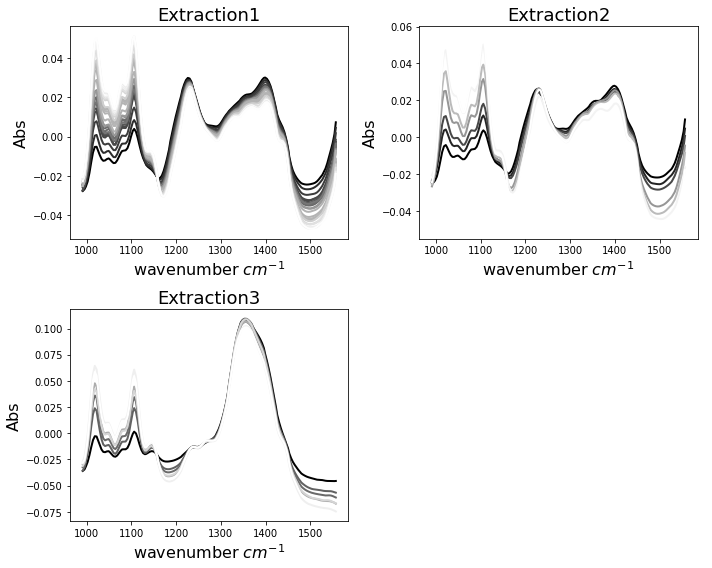

In [4]:
def plot_spectra(spectra, ax, name):
    pectin_yield = np.array(spectra.index)
    color_code = (pectin_yield - pectin_yield.min())
    color_code = color_code / color_code.max()
    color_code = color_code[:]
    for spectrum, color in zip(np.array(spectra), color_code):
        ax.plot(wavenumbers, spectrum, color=(color, color, color), linewidth=2)
        ax.set_title(name, fontsize=18)
        ax.set_xlabel('wavenumber $cm^{-1}$', fontsize=16)
        ax.set_ylabel('Abs', fontsize=16)
        plt.tight_layout()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
plot_spectra(ftir1, ax[0][0], 'Extraction1')
plot_spectra(ftir2, ax[0][1], 'Extraction2')
plot_spectra(ftir3, ax[1][0], 'Extraction3')
ax[1][1].axis('off');

If we look at all spectra plotted together we obtain the following.

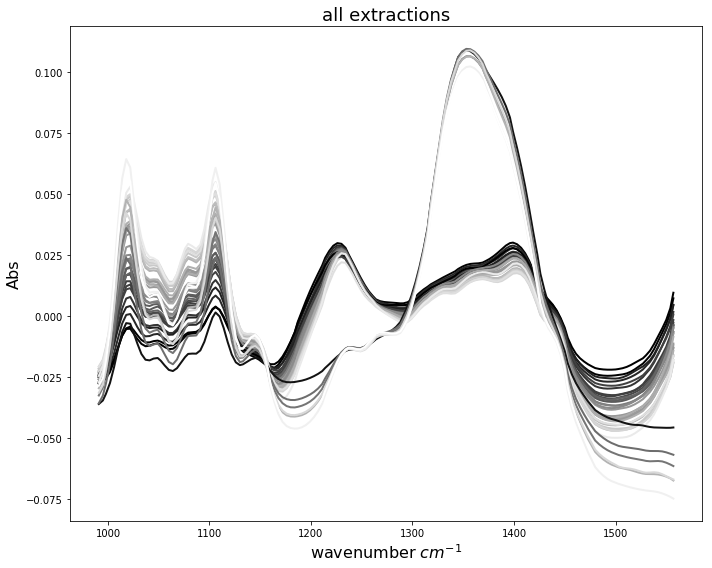

In [5]:
yield_all = np.array(ftir.index)
fig, ax = plt.subplots(figsize=(10,8))
plot_spectra(ftir, ax, 'all extractions')

## Find number of latent variables using Leave-One-Out Cross Validation
To find and the right number of latent variables (LV)  we perform cross validation. Scikit-learn makes it easy for us using the cross_val_predict function. We simply re-model the data using different numbers of latent variables and plot the result of the resulting Mean Square Errors (MSE). We pick the number of latent variables where the MSE is minimal to avoid overfitting and to induce as much complexity into our model as to obtained best possible results.

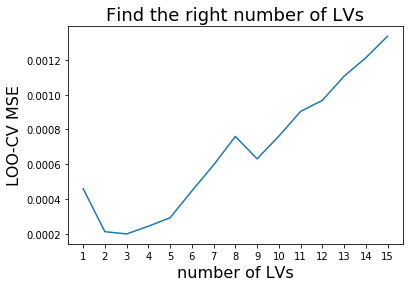

In [6]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

MSEs = []
for lv in range(15):
    mbpls = MBPLS(n_components=lv+1, method='NIPALS')
    prediction = cross_val_predict(mbpls, ftir, yield_all, cv=len(ftir))
    prediction = pd.DataFrame(prediction)
    MSEs.append(mean_squared_error(prediction, yield_all))

plt.plot(np.arange(1,16), MSEs)
plt.xlabel('number of LVs', fontsize=16)
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.ylabel('LOO-CV MSE', fontsize=16)
plt.title('Find the right number of LVs', fontsize=18);

## Plot resulting calibration and evaluate model
Once we have found the right number of latent variables we plug in this number to calculate our final model. Before we do this using all data (no CV) we want to look at the predicted versus known pectin yield plot below. As you can see our model predicts pectin yield quite well with a mean squared error of 0.0002 g.

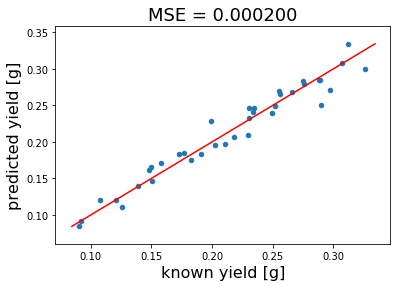

In [7]:
mbpls = MBPLS(n_components=3, method='NIPALS')
prediction = cross_val_predict(mbpls, ftir, yield_all, cv=len(ftir))
prediction = pd.DataFrame(prediction)
yield_all = pd.DataFrame(np.array(yield_all))
prediction = pd.concat((prediction, yield_all), axis=1)
prediction.columns=['predicted yield [g]', 'known yield [g]']
prediction.plot.scatter(x='known yield [g]', y='predicted yield [g]')
plt.plot([prediction.min().min(), prediction.max().max()], 
         [prediction.min().min(), prediction.max().max()], color='red')
plt.ylabel(prediction.columns[0], fontsize=16)
plt.xlabel(prediction.columns[1], fontsize=16)
plt.title('MSE = {:.6f}'.format(mean_squared_error(prediction['known yield [g]'], 
                                    prediction['predicted yield [g]'])),fontsize=18);

## Calculate final model and look at regression vector $\boldsymbol{\beta}$
Now we have validated our model and we are ready to calculate the final model using all available samples. After doing so we can plot the regression vector $\boldsymbol{\beta}$ and use it to pedict the pectin yield of future samples of similar type. To compare $\boldsymbol{\beta}$ we have plotted it below together with extraction 1 samples. It is easy to conclude which wavenumbers have positiv impact on pectin yield and vice versa.

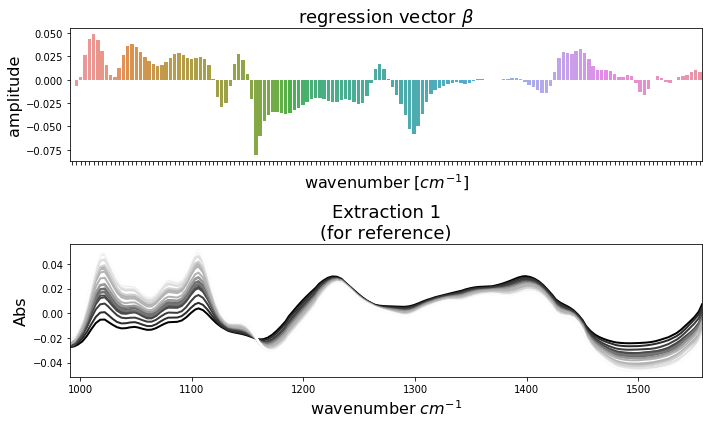

In [8]:
import seaborn as sns
mbpls = MBPLS(n_components=5, method='NIPALS')
mbpls.fit_transform(ftir, yield_all)
fig, ax = plt.subplots(nrows=2, figsize=(10,6))
sns.barplot(x=ftir.columns, y=mbpls.beta_[:,0], ax=ax[0])
ax[0].set_title('regression vector $\\beta$', fontsize=18)
ax[0].set_xlabel('wavenumber $[cm^{-1}]$', fontsize=16)
ax[0].set_ylabel('amplitude', fontsize=16)
ax[0].axes.xaxis.set_ticklabels([])
plot_spectra(ftir1, ax[1], 'Extraction 1\n(for reference)')
ax[1].set_xlim([wavenumbers.min(), wavenumbers.max()]);

## References

[1] Baum, Andreas, et al. "Prediction of pectin yield and quality by FTIR and carbohydrate microarray analysis." Food and Bioprocess Technology 10.1 (2017): 143-154.